**Generative Adversarial Networks (GANs) for Synthetic Data Generation in Finance: Evaluating Statistical Similarities and Quality Assessment **
---


In [ ]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import *
from keras.layers import Dense, BatchNormalization
from keras.callbacks import EarlyStopping
from numpy.random import randn


**load the dataset**
----

There is some contraints on the given dataset, the dataset is private and high confidential, we are not allow to public the dataset.

In [ ]:
from google.colab import files
uploaded= files.upload()

Saving train.csv to train.csv


In [ ]:
train_data = pd.read_csv("train.csv", header=None, names=[0,1,2,3])

In [ ]:
from google.colab import files
uploaded= files.upload()

In [ ]:
# Tabular synthetic data uploading
synthetic_tbGan_data = pd.read_csv("synthetic_tbGan.csv", header=None, names=[0,1,2,3])

Data analysis and exploration
---

In [ ]:
train_data.head()

,0,1,2,3
0,0.012495,0.011126,0.003252,0.006625
1,0.011439,0.002691,0.001206,0.006947
2,0.000632,0.007277,0.004049,0.000074
3,0.017828,0.028210,0.007758,0.007382
4,0.021115,0.019642,0.009238,0.011499


In [ ]:
print('Type of data',type(train_data))
print('length of the data', len(train_data))
print('no of columns', train_data.columns)

Type of data <class 'pandas.core.frame.DataFrame'>
length of the data 746
no of columns Int64Index([0, 1, 2, 3], dtype='int64')


Archiecture of Network model





---
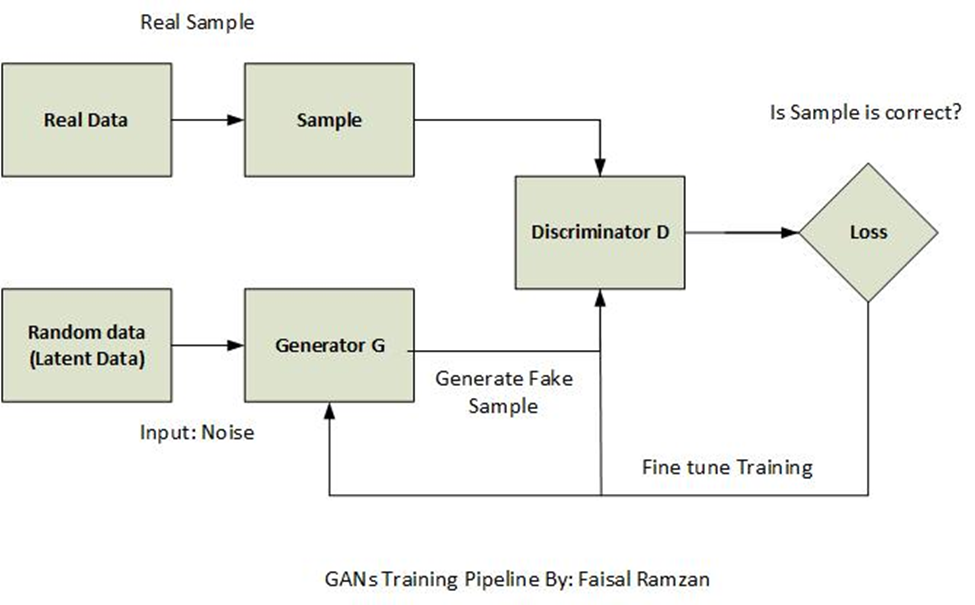

latent points
----

First step, with the help of generate_latent_points function, it will create random noise in the latent space and be reshaped to the dimensions for matching the input of generator model.

Latent space is responsible to generate random noise points in the space and reshaped them into such dimension that generator take those point as an input. Generator G take takes latent point as an input and produce the fake sample, the label of those fake point will be 0. From the real data we select some random real sample and label of those point is 1.

In [ ]:
# generate points in latent space with regularization and clamping
def generate_latent_points(latent_dim, n_samples):
    # generate random points in latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)

    # Regularization: Clip values to ensure they fall within a desired range
    x_input = np.clip(x_input, -1, 1)  # adjust the range as needed

    return x_input

# use the generator to generate n fake examples, responsible for noise injection
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space with regularization and clamping
    x_input = generate_latent_points(latent_dim, n_samples)

    # Noise injection: Introduce controlled randomness into the latent space
    noise = np.random.normal(0, 0.1, size=(n_samples, latent_dim))
    x_input += noise

    # predict outputs with fake values
    X = generator.predict(x_input)

    # create class labels
    y = np.zeros((n_samples, 1))  # reshape the generated sample, for the fake or synthetic data, we use 0

    return X, y


Real sample
---
generate_real_sample function is to generate real samples, it will randomly select samples from the real dataset (input).

In [ ]:
# generate n real samples with class labels
def generate_real_samples(n):
    X = train_data.sample(n)
  #generate class labels
    y = np.ones((n, 1))  # this is label for real or original data
    return X, y


Generator Model
---

The generator G can use the outcome from the discriminator, the generator can generate the data that can be classified by the discriminator as the real data or real samples. The neural network architecture of the generator model is similar to the discriminator. The generator takes the random latent noisy point as an input and those point can be classified from the discriminator, the classification result from discriminator is a generator loss which punish the generator because of non-fooling the discriminator model. Generator can only rely on the latent point or generated noisy distribution to generate the fake samples and those fake samples can feed as input to the discriminator because of the classification purpose between the real and fake samples.


In [ ]:
# Define the standalone generator model
def define_generator(latent_dim, n_outputs=4):
    model = Sequential()
    model.add(Dense(32, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(n_outputs, activation='linear'))
    return model

**Descriminator Model**

The GANs model work as the two-player game, the discriminator D is a classifier that receive the real and synthetic point from the generator G and start to classify between the real and fake samples. Discriminator D is simple sequential keras model including dense layers, it depends on the designer of the model that how many numbers of layers used in the model, the purpose of these layer to extract the input features and the output of these layers are activated with “Relu” function. The activation function is responsible to transform the feature into the next layer. Rectified linear activation function can work on only positive number otherwise it will return with 0 (if x>0 return 1 else 0). The final or output layer in the discriminator model can be activated by the “sigmoid” activation function because this layer is used for the classification purpose to discriminate the input sample are real (1) or fake (0).

In [ ]:
# Define the standalone discriminator model
def define_discriminator(n_inputs=4):
    model = Sequential()
    model.add(Dense(64, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

It is also a sequential model and combine generator with discriminator. NOTE: the discriminator model weight must be not trainable

In [ ]:
# combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

In [ ]:
!pip install plot_keras_history

In [ ]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt
# create a line plot of loss for the gan and save to file
def plot_history(d_hist, g_hist):
	# plot loss
	plt.subplot(1, 1, 1)
	plt.plot(d_hist, label='d')
	plt.plot(g_hist, label='gen')
	plt.show()
	plt.close()

**Model Training**
---

In [ ]:
# Modify the EarlyStopping callback creation
early_stopping = EarlyStopping(monitor='d_loss', patience=10, restore_best_weights=True)

# Modify the train function
def train(g_model, d_model, gan_model, latent_dim, n_epochs=1000, n_batch=128, callbacks=[early_stopping]):

    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    d_history = []
    g_history = []

    # manually enumerate epochs
    for epoch in range(n_epochs):
        # prepare real samples
        x_real, y_real = generate_real_samples(half_batch)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator and training on real sample called x_real
        d_loss_real, d_real_acc = d_model.train_on_batch(x_real, y_real)
        d_loss_fake, d_fake_acc = d_model.train_on_batch(x_fake, y_fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)

        # create inverted labels for the fake samples
        y_gan = np.ones((n_batch, 1))

        # update the generator via the discriminator's error or loss which penalize the G and retrained model again
        g_loss_fake = gan_model.train_on_batch(x_gan, y_gan)
        #print('>%d, D_real_loss=%.3f, D_fake_loss=%.3f d_combine_loss=%.3f gan_loss=%.3f' % (epoch+1, d_loss_real, d_loss_fake, d_loss,  g_loss_fake))
        print('>%d, d1=%.3f, d2=%.3f d=%.3f g=%.3f' % (epoch+1, d_loss_real, d_loss_fake, d_loss,  g_loss_fake))
        d_history.append(d_loss)
        g_history.append(g_loss_fake)

        # Evaluate early stopping criteria
        if callbacks:
            if callbacks[0].monitor_op(d_loss, callbacks[0].best):
                callbacks[0].best = d_loss
                callbacks[0].wait = 0
            else:
                callbacks[0].wait += 1

            if callbacks[0].wait >= callbacks[0].patience:
                print("Early stopping, epoch =", epoch+1)
                break

    plot_history(d_history, g_history)
    g_model.save('trained_generated_model_20210205_v3.h5')


In [ ]:
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
	# prepare real samples
	x_real, y_real = generate_real_samples(n)
	# evaluate discriminator on real examples
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
	# evaluate discriminator on fake examples
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print(epoch, acc_real, acc_fake)
  # scatter plot real and fake data points
	pyplot.scatter(x_real[:, 0], color='red')
	pyplot.scatter(x_fake[:, 0], color='blue')
	pyplot.show()

Given a small latent space, the AE produces low quality and the GAN
produces high quality outputs from a perceptual viewpoint. In contrast, the distortion error is smaller for the AE. By increasing the dimensionality of the latent space the distortion decreases for both models, but the perceptual quality only increases for the AE. ref: https://openreview.net/forum?id=Hygy01StvH

In [ ]:
# size of the latent space
latent_dim = 10
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
# Call the train function with the generator, discriminator, GAN model, latent_dim, and other parameters
train(generator, discriminator, gan_model, 10, n_epochs=1000, n_batch=128, callbacks=[early_stopping])

**Evaluate the Quality of Generated Fake Data**
---


In [ ]:
# load the save model
from keras.models import load_model
model = load_model('/content/trained_generated_model_20210205_v3.h5')

In [ ]:
#save the model weights
weights = model.get_weights() # Getting parameters from the model
weights=pd.DataFrame(weights)
weights.to_csv('parameters.csv', index=False, header=None)

/usr/local/lib/python3.7/dist-packages/pandas/core/internals/construction.py:305: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [ ]:
latent_points = generate_latent_points(10, 408)  # we use according to our dataset

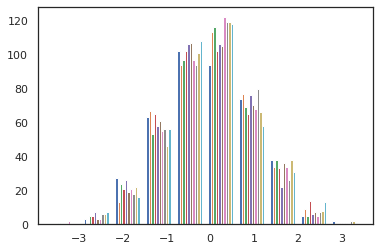

In [ ]:
plt.hist(latent_points,bins=10)
plt.show()

In [ ]:
Noise=pd.DataFrame(latent_points)

In [ ]:
#download the csv of fake data or Noisy point
Noise.to_csv('Noise.csv', index=False, header=None)

In [ ]:
X = model.predict(Noise)

In [ ]:
synthetic_data = pd.DataFrame(data=X)

In [ ]:
#download the csv of fake data
synthetic_data.to_csv('synthetic_data.csv', index=False,header=None)

In [ ]:
synthetic_data.head()

,0,1,2,3
0,0.020167,-0.003071,0.009759,0.013813
1,0.017501,-0.001190,0.001552,-0.003804
2,0.015769,0.003850,0.008949,0.012402
3,0.022868,0.008320,0.012518,0.008774
4,0.002438,0.004125,0.002312,0.005144


In [ ]:
print('Description of Synthetic data\n',synthetic_data.describe())
print('Description of real data\n',train_data.describe())

Description of Synthetic data
                 0           1           2           3
count  800.000000  800.000000  800.000000  800.000000
mean     0.013444    0.011190    0.007740    0.008747
std      0.009360    0.008199    0.006420    0.005592
min     -0.016773   -0.007279   -0.007621   -0.006390
25%      0.008760    0.005814    0.003925    0.005191
50%      0.011961    0.009404    0.006464    0.007714
75%      0.015741    0.014324    0.010097    0.011294
max      0.133790    0.066734    0.043531    0.040680
Description of real data
                 0           1           2           3
count  746.000000  746.000000  746.000000  746.000000
mean     0.013144    0.012822    0.009366    0.010788
std      0.011914    0.011712    0.009283    0.009338
min      0.000012    0.000057    0.000014    0.000067
25%      0.004761    0.003878    0.003202    0.004226
50%      0.010030    0.009423    0.006641    0.008508
75%      0.017771    0.017810    0.012354    0.014221
max      0.098709    0.08

**Evaluate the Quality of Generated Fake Data With Table_evaluator**
---
Table_evaluator is a library to evaluate how similar a synthesized dataset is to a real dataset. It is suitable for evaluating the generated synthetic data. First we will install the table_evaluator module.


In [ ]:
!pip install table_evaluator

In [ ]:
from table_evaluator import load_data, TableEvaluator
table_evaluator = TableEvaluator(train_data, synthetic_data)

In [ ]:
table_evaluator.visual_evaluation()

Distribution plot
---


Blue show the original while the Orange show the Synthetic Data or Newly generated data:


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).



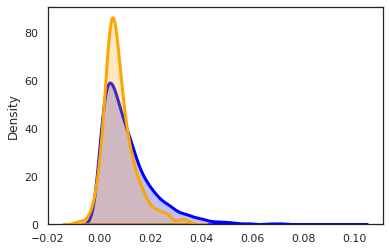

In [ ]:
import seaborn as sns
print('Blue show the original while the Orange show the Synthetic Data or Newly generated data:')
sns.distplot(dt, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},
                  label = train_data, color='blue');
sns.distplot(synthetic_data, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},
                  label = train_data, color='Orange');
plt.show()


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).



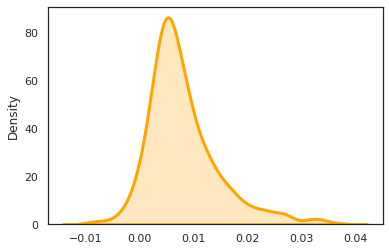

In [ ]:
import seaborn as sns
sns.distplot(synthetic_data, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},
                  label = train_data, color='orange')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).



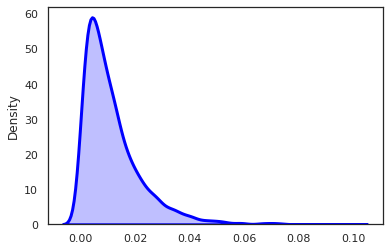

In [ ]:
import seaborn as sns
sns.distplot(dt, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},
                  label = train_data, color='blue')

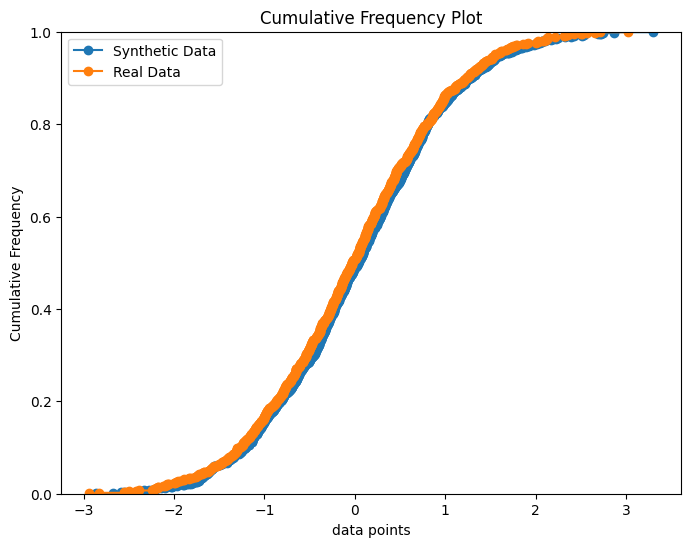

In [ ]:
# Cumulative frequency plot
plt.figure(figsize=(8, 6))

sns.ecdfplot(synthetic_data, label='Synthetic Data', marker='o')
sns.ecdfplot(train_data, label='Real Data', marker='o')

plt.title('Cumulative Frequency Plot')
plt.xlabel('data points')
plt.ylabel('Cumulative Frequency')
plt.legend()
plt.show()


Column names in real data:
Index(['0', '1', '2', '3'], dtype='object')

Column names in synthetic data:
Index(['0', '1', '2', '3'], dtype='object')


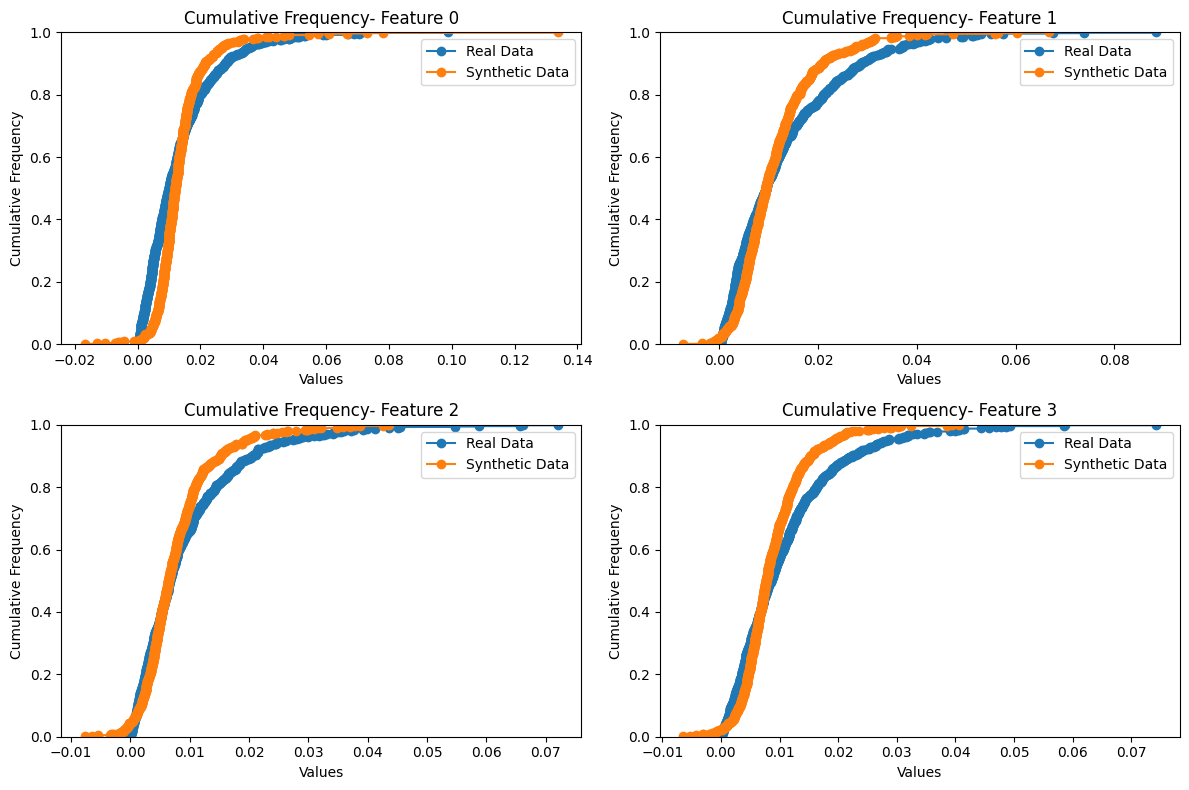

In [ ]:
# Check column names in the datasets
print("Column names in real data:")
print(train_data.columns)

print("\nColumn names in synthetic data:")
print(synthetic_data.columns)

# List of column names to plot
columns_to_plot = ['0', '1', '2', '3']

# Create individual cumulative frequency plots for each column
plt.figure(figsize=(12, 8))

for col in columns_to_plot:
    plt.subplot(2, 2, columns_to_plot.index(col) + 1)
    sns.ecdfplot(data=train_data[col], label='Real Data', marker='o')
    sns.ecdfplot(data=synthetic_data[col], label='Synthetic Data', marker='o')
    plt.xlabel('Values')
    plt.ylabel('Cumulative Frequency')
    plt.title(f'Cumulative Frequency- Feature {col}')
    plt.legend()

plt.tight_layout()
plt.show()


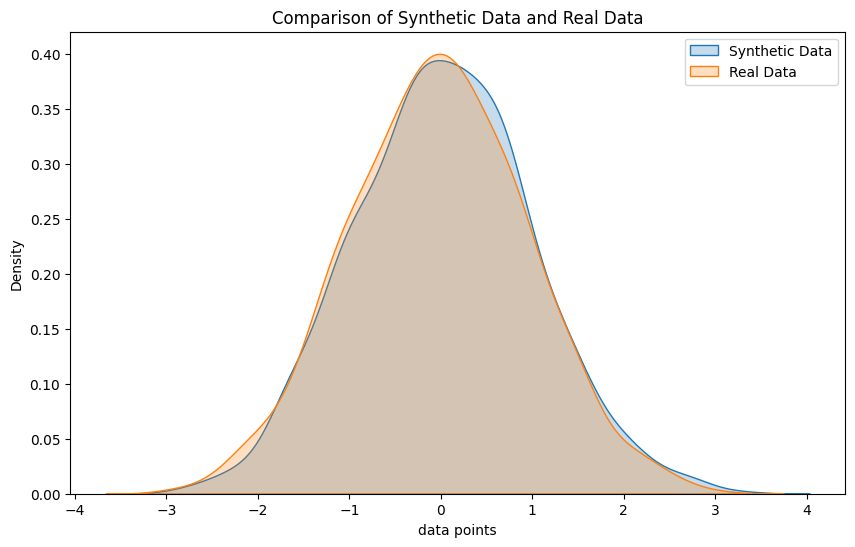

In [ ]:
plt.figure(figsize=(10, 6))
# Plotting both datasets
sns.kdeplot(synthetic_data, label='Synthetic Data', fill=True)
sns.kdeplot(train_data, label='Real Data', fill=True)

plt.title('Comparison of Synthetic Data and Real Data')
plt.xlabel('data points')
plt.ylabel('Density')
plt.legend()
plt.show()


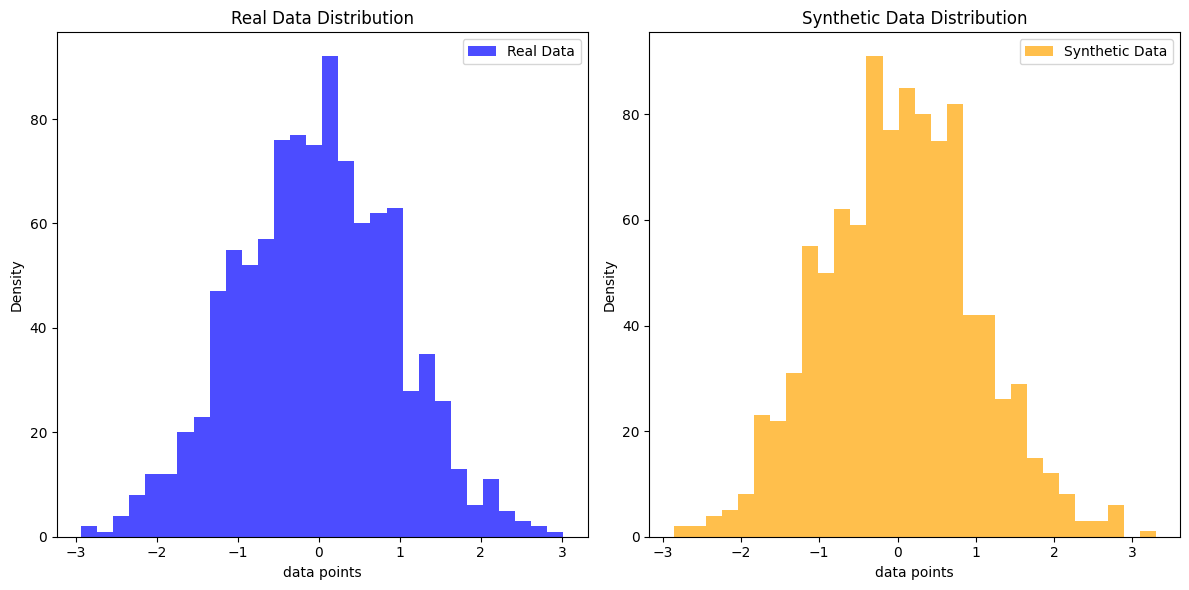

In [ ]:

# Other visualizations
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(train_data, bins=30, alpha=0.7, color='blue', label='Real Data')
plt.xlabel('data points')
plt.ylabel('Density')
plt.title('Real Data Distribution')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(synthetic_data, bins=30, alpha=0.7, color='orange', label='Synthetic Data')
plt.xlabel('data points')
plt.ylabel('Density')
plt.title('Synthetic Data Distribution')

plt.legend()

plt.tight_layout()
plt.show()


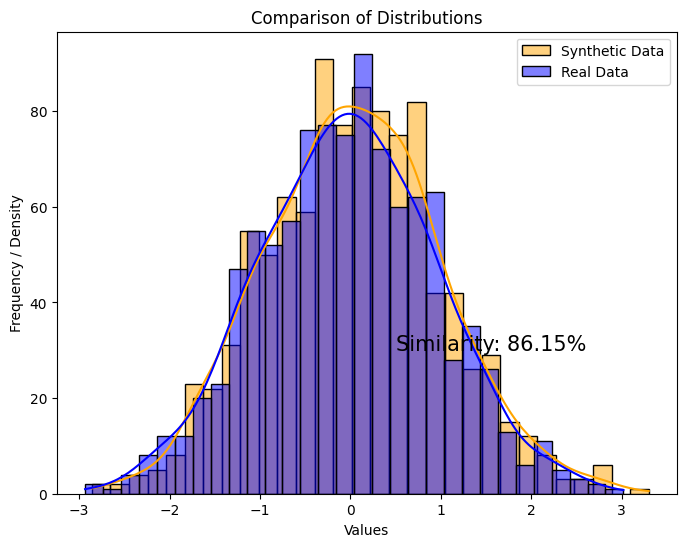

In [ ]:
# Plotting the histograms or density plots for both datasets
plt.figure(figsize=(8, 6))

sns.histplot(synthetic_data, bins=30, kde=True, label='Synthetic Data', color='orange')
sns.histplot(train_data, bins=30, kde=True, label='Real Data', color='blue')

plt.title('Comparison of Distributions')
plt.xlabel('Values')
plt.ylabel('Frequency / Density')
plt.legend()

# Calculate similarity
intersection = np.sum((synthetic_data > np.min(train_data)) & (synthetic_data < np.max(train_data)))
similarity_percentage = (intersection / len(synthetic_data)) * 100

plt.text(0.5, 30, f'Similarity: {similarity_percentage:.2f}%', ha='center', fontsize=12)

plt.show()

Column names in real data:
Index(['0', '1', '2', '3'], dtype='object')

Column names in synthetic data:
Index(['0', '1', '2', '3'], dtype='object')


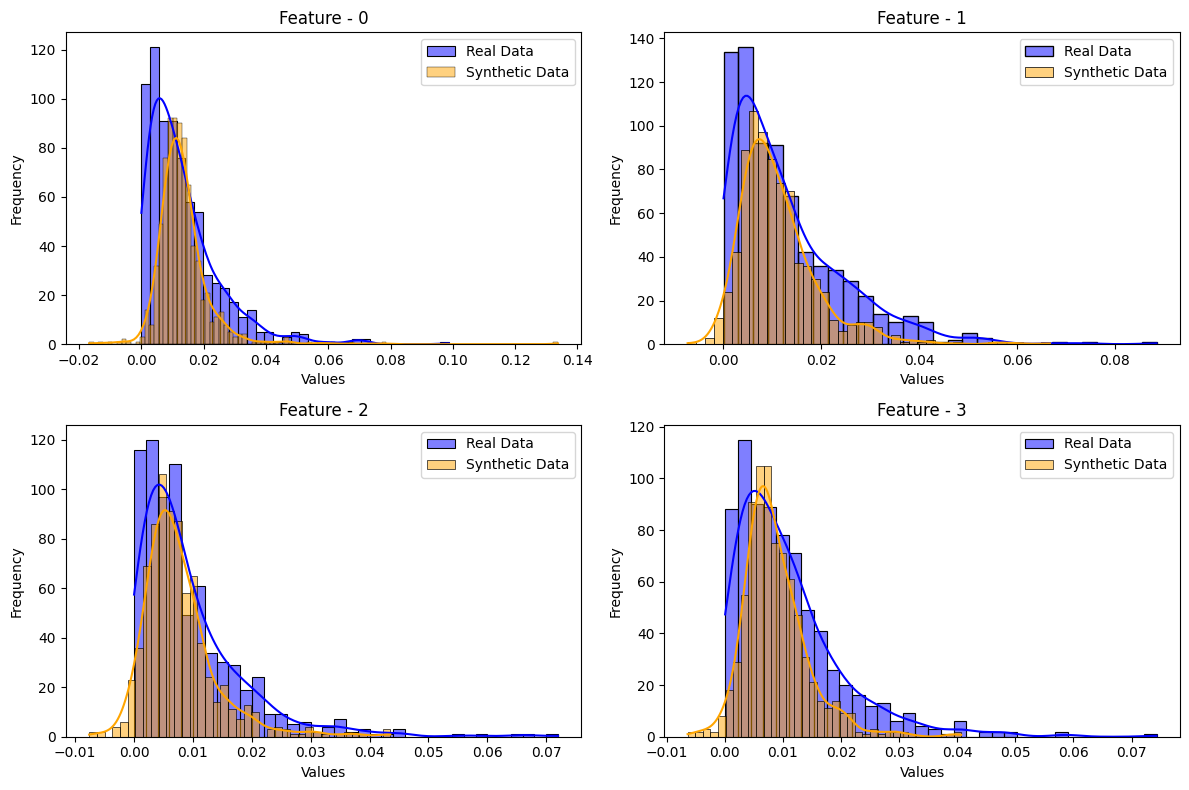

In [ ]:
# Check column names in the datasets
print("Column names in real data:")
print(train_data.columns)

print("\nColumn names in synthetic data:")
print(synthetic_data.columns)

# List of column names to plot
columns_to_plot = ['0', '1', '2', '3']

# Create a 2x2 grid of histograms for each column
plt.figure(figsize=(12, 8))

for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.histplot(train_data[col], label='Real Data', kde=True, color="blue")
    sns.histplot(synthetic_data[col], label='Synthetic Data', kde=True, color="orange")
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title(f'Feature - {col}')
    plt.legend()

plt.tight_layout()
plt.show()


## Evaluation metric
Evaluation on different dataset, Generated by TabularGAN and with our FinGan

1. TabularGan
2. FinGan


In [6]:
# TabularGan dataset evaluation
import numpy as np
from scipy.stats import wasserstein_distance
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import energy_distance
from scipy.stats import entropy
from scipy.stats import ks_2samp

train_data_values = train_data.values.flatten()
syn_dt_Tabular_GAN = synthetic_tbGan_data.values.flatten()

# Calculate various evaluation metrics
kl_divergence = entropy(train_data_values, syn_dt_Tabular_GAN)

wasserstein_dist = wasserstein_distance(train_data_values, syn_dt_Tabular_GAN)

# mse = mean_squared_error(train_data_values, synthetic_data_values)

mmd = np.mean(euclidean_distances(np.expand_dims(train_data_values, axis=1),
                                  np.expand_dims(syn_dt_Tabular_GAN, axis=1)))

energy_dist = energy_distance(train_data_values, syn_dt_Tabular_GAN)

# Displaying the calculated metrics
print(f"KL Divergence: {kl_divergence}")
print(f"Wasserstein Distance: {wasserstein_dist}")
# print(f"Mean Squared Error: {mse}")
print(f"Maximum Mean Discrepancy (MMD): {mmd}")
print(f"Energy Distance: {energy_dist}")

KL Divergence: 0.3579473547091846
Wasserstein Distance: 0.6024859204652718
Maximum Mean Discrepancy (MMD): 0.19673046210437525
Energy Distance: 0.2203498531789364


In [ ]:
# FinGAN dataset evaluation
synthetic_data_values = synthetic_data.values.flatten()

# evaluation metrics
kl_divergence = entropy(train_data_values, synthetic_data_values)

wasserstein_dist = wasserstein_distance(train_data_values, synthetic_data_values)

mmd = np.mean(euclidean_distances(np.expand_dims(train_data_values, axis=1),
                                  np.expand_dims(synthetic_data_values, axis=1)))

energy_dist = energy_distance(train_data_values, synthetic_data_values)

# Displaying the calculated metrics
print(f"KL Divergence: {kl_divergence}")
print(f"Wasserstein Distance: {wasserstein_dist}")
print(f"Maximum Mean Discrepancy (MMD): {mmd}")
print(f"Energy Distance: {energy_dist}")


KL Divergence: 0.002156329874523699
Wasserstein Distance: 0.0023967692525434384
Maximum Mean Discrepancy (MMD): 0.009315341278636747
Energy Distance: 0.01705238338710266
